In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import importlib
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy
from gudhi.representations import Landscape, PersistenceImage

import topofisher 
from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer
from topofisher.filtrations.tensorflow.dtm_layer import DTMFiltLayer, NNFiltLayer
from topofisher.filtrations.tensorflow.filt_utils import ExtraDimFiltLayer
from topofisher.filtrations.visualization import visualizeFiltrations

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

from topofisher.vectorizations.tensorflow.custom_vectorizations import TOPK_TF
from topofisher.vectorizations.tensorflow.vectorization_layer import VectorizationLayers_TF

from topofisher.fisher.Fisher import show_fm_and_bias, fisherMOPED
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer, plot_loss
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
from topofisher.pipelines.utils import readFromFile, writeToFile

import gudhi.representations as gdr
import gudhi.tensorflow.perslay as prsl
from gudhi.point_cloud.knn import KNearestNeighbors
from topofisher.input_simulators.noisy_ring import CircleSimulator
import gudhi

2023-10-09 09:03:11.255122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 09:03:19.431592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
theta_fid = tf.constant([1., 0.2])
delta_theta = tf.constant([0.1, 0.02])
num_sims = 10000
circle_simulator = CircleSimulator(200, 20, 1.)

In [43]:
all_pts = circle_simulator.generateData(theta_fid, delta_theta, n_s = num_sims, n_d = num_sims, seed_cov = 42, \
                              seed_ders = [43, 44], find_derivative = [True, False])

### Preparing the model

In [44]:
num_nn = 110
phi = tf.keras.Sequential([tf.keras.layers.Dense(num_nn//2, input_shape = (None, num_nn - 1), activation = "sigmoid"), \
                          tf.keras.layers.Dense(1)])
phi.build()

initial_phi=  tf.keras.models.clone_model(phi)
initial_phi.set_weights(phi.get_weights()) 
filtLayer = ExtraDimFiltLayer(NNFiltLayer(num_nn = num_nn, max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, \
                                       is_ragged = True, data_format = "hom_dim_first", phi = phi,
                                        batched_gather = False
                                         )
                              )

In [45]:
vectorizations = [TOPK_TF(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 25), \
                  TOPK_TF(bdp_type = "bd", is_binned = True, topk = 29, num_bins = 5)]
vecLayer = ExtraDimLayer(VectorizationLayers_TF(vectorizations = vectorizations, data_format = "hom_dim_first"))

In [46]:
model = tf.keras.Sequential(
    [filtLayer, vecLayer]
)

### Training the model

In [47]:
pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 15, data_splits = [0.4, 0.2, 0.4], \
                          callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)], moped = True, \
                          run_eagerly = True, 
                          batch_size = 4000, show_bias = True)
fisher = pi_imnn_layer.computeFisher(all_pts, delta_theta[0:1])

Epoch 1/15
1/1 [==============================] - 404s 404s/step - loss: -8.0442 - bias0: 0.0025 - val_loss: -7.9995 - val_bias0: 0.0032
Epoch 2/15
1/1 [==============================] - 427s 427s/step - loss: -8.0450 - bias0: 0.0016 - val_loss: -8.0092 - val_bias0: 0.0029
Epoch 3/15
1/1 [==============================] - 378s 378s/step - loss: -8.0803 - bias0: 0.0018 - val_loss: -8.0033 - val_bias0: 0.0024
Epoch 4/15
1/1 [==============================] - 388s 388s/step - loss: -8.0668 - bias0: 0.0020 - val_loss: -7.9878 - val_bias0: 0.0029
Epoch 5/15
1/1 [==============================] - 372s 372s/step - loss: -8.0832 - bias0: 0.0017 - val_loss: -8.0053 - val_bias0: 0.0028


### Results

In [48]:
show_fm_and_bias(fisher)

FM =  [3215.64]
Fractional bias =  [0.]


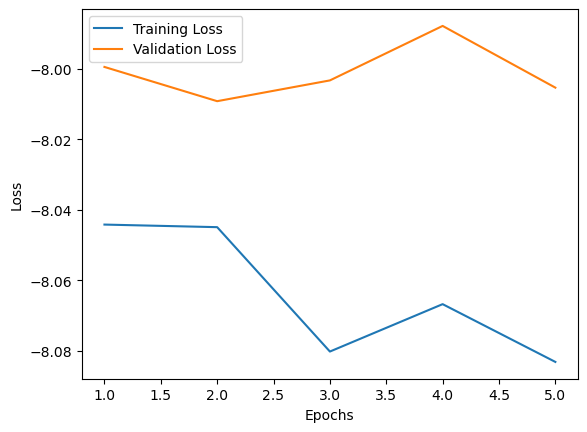

In [49]:
plot_loss(pi_imnn_layer.history)

#### Comparing with the filtration function before training

In [35]:
num_test_pts = int(num_sims * pi_imnn_layer.data_splits[2])
test_pts = tf.einsum("ij...->ji...", tf.stack([item[-num_test_pts:, :, :] for item in all_pts]))
initial_filtLayer = ExtraDimFiltLayer(NNFiltLayer(num_nn = num_nn, max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, \
                                       is_ragged = True, data_format = "hom_dim_first", phi = initial_phi
                                         )
                              )
model_before_training = tf.keras.Sequential(
    [initial_filtLayer, vecLayer]
)

In [36]:
op = model_before_training(test_pts)
fisher = topofisher.fisher.Fisher.fisherMOPED(tf.transpose(op, (1, 0, 2)), delta_theta[0:1])
print("Before Training")
show_fm_and_bias(fisher)
op = model(test_pts)
fisher_after_training = topofisher.fisher.Fisher.fisherMOPED(tf.transpose(op, (1, 0, 2)), delta_theta[0:1])
print("After Training")
show_fm_and_bias(fisher_after_training)

2023-10-09 10:28:19.257058: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedGather/RowPartitionFromRowSplits/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_46
2023-10-09 10:28:28.918917: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RowPartitionFromRowLengths_1/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_156
2023-10-09 10:28:59.811722: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RowPartitionFromRowLengths_1/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_156
2023-10-09 10:29:24.516314: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedGather_1/RowPartitionFromRowSplits/assert_non_negative/asser

Before Training
FM =  [2685.4]
Fractional bias =  [0.]
After Training
FM =  [3308.9]
Fractional bias =  [0.]


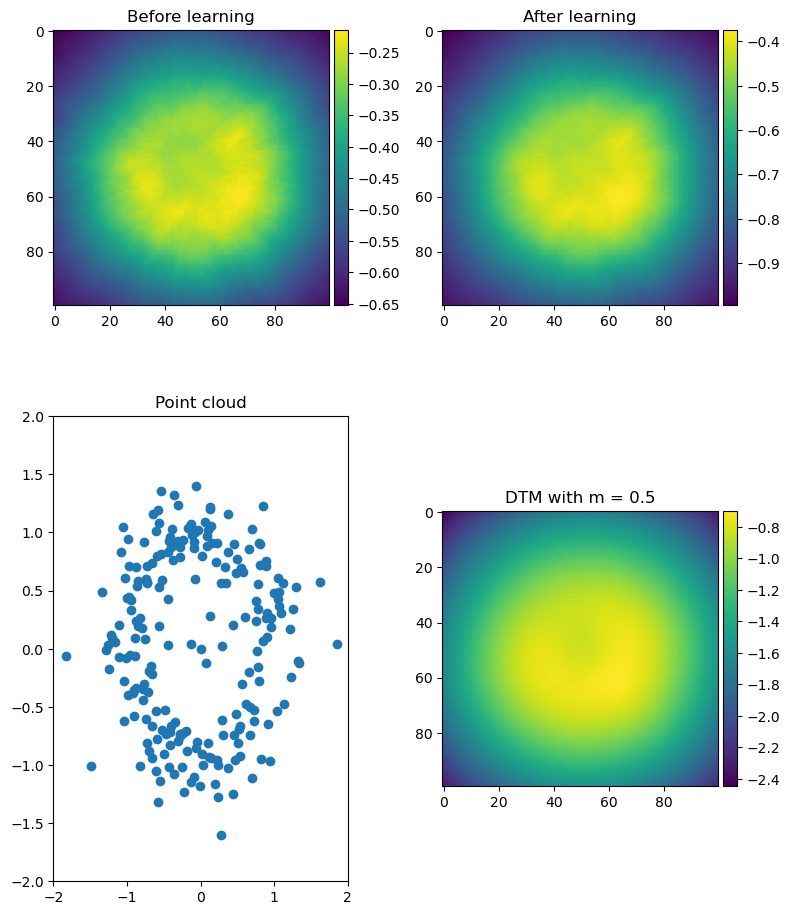

In [52]:
ind = np.random.randint(num_sims)
visualizeFiltrations(initial_phi, phi, num_nn = num_nn, pts = all_pts[0][ind], sgn = 1., extent = [-2, 2])